## INT305 Assignment 2 Image Object Classification (CIFAR-10)

### Test CUDA

In [3]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

### Load the Data

In [4]:
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data.sampler import SubsetRandomSampler

number_of_workers = 0
valid_size= 0.2


#  Converting Data into a Normalized Tensor format
transform = transforms.Compose([
                                #transforms.Resize(512),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std= (0.5, 0.5, 0.5))
])

# Downloading training and testing Datasets
train_data= datasets.CIFAR10('data', train= True,
                             download= True, transform = transform)
test_data = datasets.CIFAR10('data', train = False,
                             download = True, transform= transform)

# Obtaining training Indices that we are going to use for Validation Set
num_train= len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
# 打乱索引顺序
split = int(np.floor(valid_size * num_train))
# 划分训练和验证
train_idx, valid_idx = indices[split:] , indices[:split]

# Defining samplers for training and validation Bathces
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Define arguments
def parse_args():
    parser = argparse.ArgumentParser(description='CNN Training on CIFAR-10')
    
    parser.add_argument('--batch_size', type=int, default=10, help='Input batch size for training (default: 10)')
    parser.add_argument('--valid_size', type=float, default=0.2, help='Size of validation set (default: 0.2)')
    parser.add_argument('--learning_rate', type=float, default=0.0001, help='Learning rate (default: 0.0001)')
    parser.add_argument('--n_epochs', type=int, default=300, help='Number of epochs to train (default: 300)')
    
    args = parser.parse_args()
    return args

In [4]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 使用预训练的 ResNet18
        self.pretrained_resnet = models.resnet18(pretrained=True)
        # 冻结预训练模型的参数
        #for param in self.pretrained_resnet.parameters():
            #param.requires_grad = False
        
        # 移除 ResNet18 的最后的全连接层
        self.features = nn.Sequential(*list(self.pretrained_resnet.children())[:-1])

        # 调整全连接层以匹配 ResNet18 的输出特征大小
        self.fc1 = nn.Linear(512, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # 使用 ResNet18 提取特征
        x = self.features(x)
        x = torch.flatten(x, 1)

        # 应用全连接层
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# 如果 CUDA 可用，将模型移至 GPU
if train_on_gpu:
    model.cuda()

/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
def feature_calc(num_channels, k_size, stride , pad):
  calc_result=(((num_channels - k_size + 2 * pad ) / stride) + 1)
  return calc_result

a1=feature_calc(32, 2, 1, 1)
a2=feature_calc(np.floor(a1), 2, 2, 0)
a3=feature_calc(np.floor(a2), 2, 1, 1)
a4= feature_calc(np.floor(a3), 2, 2, 0)
a5= feature_calc(np.floor(a4), 2, 1, 0)
a6= feature_calc(np.floor(a5), 2, 2, 0)

print(a1, a2, a3, a4, a5, a6)

33.0 16.5 17.0 8.5 7.0 3.5


In [13]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

# Define the learning rate schedulers
def learning_rate_scheduler(optimizer, scheduler_type):
    if scheduler_type == 'stepLR':
        return lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    elif scheduler_type == 'exp':
        return lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Define the optimizer selector
def optimizer_selector(optimizer, learning_rate, weight_decay_number):
    if optimizer == 'SGD':
        return optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9, weight_decay = weight_decay_number)
    if optimizer == 'Adam':
        return optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay_number)

### Grid Search Method

In [14]:
import torch.optim as optim
import itertools

# Define parameters
batch_size = 10
learning_rate = 1e-4
n_epochs = 200
class_names =['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Grid search parameter settings
optimizers_list = ['SGD', 'Adam']
weight_dacay_numbers_list = [0.001, 0.0001] 
schedulers_list = ['stepLR', 'exp']
grid_search_results = []

# 开始网格搜索
for optimizer_type, weight_decay_number, scheduler_type in itertools.product(optimizers_list, weight_dacay_numbers_list, schedulers_list):
    
    model_filename = f'model_cifar10_opt{optimizer_type}_wd{weight_decay_number}_sch{scheduler_type}.pt'
    
    # 更新DataLoaders
    # Preparing Data Loader for all three sets (combining datasets and samplers)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = train_sampler , num_workers = number_of_workers)
    valid_loader= torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = valid_sampler, num_workers = number_of_workers)
    test_loader= torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers = number_of_workers)

    # specify loss function
    criterion = nn.CrossEntropyLoss()

    # specify optimizer
    optimizer = optimizer_selector(optimizer_type, learning_rate, weight_decay_number)
    scheduler = learning_rate_scheduler(optimizer, scheduler_type)

    # track change in validation loss
    valid_loss_min = np.Inf

    # 在训练循环之前初始化计数器
    epoch_no_improvement_count = 0
    
    for epoch in range(1, n_epochs + 1):
        
        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
    
        ###################
        # train the model #
        ###################
        model.train()
        for data, target in train_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda() 
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item() * data.size(0)
        
        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item() * data.size(0)
            
        scheduler.step()
    
        # calculate average losses
        train_loss = train_loss / len(train_loader.dataset)
        valid_loss = valid_loss / len(valid_loader.dataset)
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
            print('---------------------------------------------------------------------------------------------------')
            torch.save(model.state_dict(), model_filename)
            valid_loss_min = valid_loss
        else:
            print('---------------------------------------------------------------------------------------------------')
    
    ######################    
    # test the model #
    ######################
    model.load_state_dict(torch.load(model_filename))
        
    # track test loss
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval()
    # iterate over test data
    for data, target in test_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item() * data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)    
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(target.size(0)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1      
    
    # average test loss
    test_loss = test_loss / len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    
    overall_test_accuracy = 100. * np.sum(class_correct) / np.sum(class_total)
    
    #for i in range(10):
    #   if class_total[i] > 0:
     #       print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (class_names[i], 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
      #  else:
       #     print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    #print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))
    
    grid_search_results.append((optimizer, weight_decay_number, scheduler_type, overall_test_accuracy))
    
    # print the results
    for result in grid_search_results:
        print('Optimizer: {}, Weight Decay: {}, Scheduler: {}, Overall Test Accuracy: {:.2f}%'.format(*result))
        print('---------------------------------------------------------------------------------------------------')


print('***************************************************************************************************')
print('Grid Search Finished!')
print('***************************************************************************************************')


# print the results
for result in grid_search_results:
    print('Optimizer: {}, Weight Decay: {}, Scheduler: {}, Overall Test Accuracy: {:.2f}%'.format(*result))
    print('---------------------------------------------------------------------------------------------------')

Epoch: 1 	Training Loss: 1.527110 	Validation Loss: 0.265680
Validation loss decreased (inf --> 0.265680).  Saving model ...
---------------------------------------------------------------------------------------------------
Epoch: 2 	Training Loss: 1.036985 	Validation Loss: 0.200833
Validation loss decreased (0.265680 --> 0.200833).  Saving model ...
---------------------------------------------------------------------------------------------------
Epoch: 3 	Training Loss: 0.903142 	Validation Loss: 0.176671
Validation loss decreased (0.200833 --> 0.176671).  Saving model ...
---------------------------------------------------------------------------------------------------
Epoch: 4 	Training Loss: 0.822691 	Validation Loss: 0.168210
Validation loss decreased (0.176671 --> 0.168210).  Saving model ...
---------------------------------------------------------------------------------------------------
Epoch: 5 	Training Loss: 0.773195 	Validation Loss: 0.153365
Validation loss decrease

### Train and validate the baseline model

Epoch: 1 	Training Loss: 1.463695 	Validation Loss: 0.250221
Validation loss decreased (inf --> 0.250221).  Saving model ...
---------------------------------------------------------------------------------------------------
Epoch: 2 	Training Loss: 1.024232 	Validation Loss: 0.201217
Validation loss decreased (0.250221 --> 0.201217).  Saving model ...
---------------------------------------------------------------------------------------------------
Epoch: 3 	Training Loss: 0.896934 	Validation Loss: 0.174088
Validation loss decreased (0.201217 --> 0.174088).  Saving model ...
---------------------------------------------------------------------------------------------------
Epoch: 4 	Training Loss: 0.816872 	Validation Loss: 0.162411
Validation loss decreased (0.174088 --> 0.162411).  Saving model ...
---------------------------------------------------------------------------------------------------
Epoch: 5 	Training Loss: 0.756218 	Validation Loss: 0.155559
Validation loss decrease

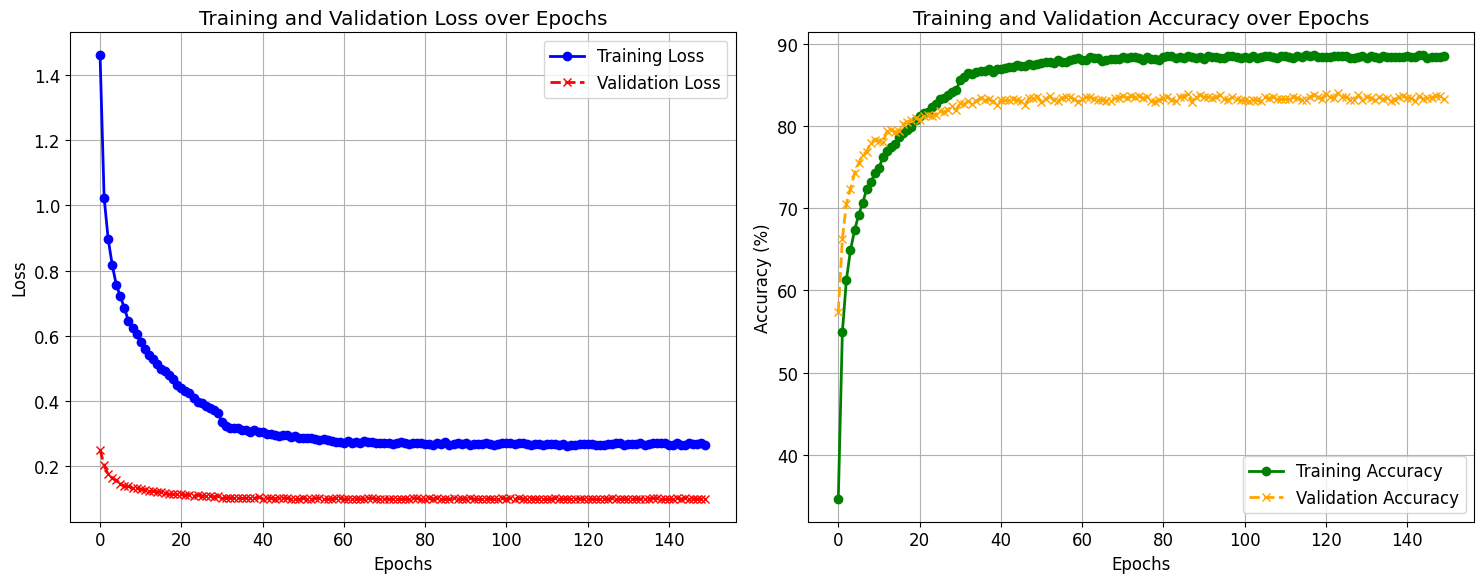

In [17]:
import torch.optim as optim
import itertools
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt

# Define parameters
batch_size = 10
learning_rate = 1e-4
n_epochs = 150
class_names =['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
model_filename = f'model_baseline_cifar10.pt'

# Creating model instances
model = Net().cuda()

# Update DataLoaders
# Preparing Data Loader for all three sets (combining datasets and samplers)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = train_sampler , num_workers = number_of_workers)
valid_loader= torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = valid_sampler, num_workers = number_of_workers)
test_loader= torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers = number_of_workers)

# Specify loss function
criterion = nn.CrossEntropyLoss()

# Specify optimizer
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9, weight_decay = 0.001)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Track change in validation loss
valid_loss_min = np.Inf

# Storage loss and accuracy
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
    
for epoch in range(1, n_epochs + 1):
        
    # Keep track of training, validation loss and training, validation accuracy
    train_loss = 0.0
    valid_loss = 0.0
    train_correct_number = 0
    train_total_total_number = 0
    valid_correct_number = 0
    total_total_valid_number = 0
    
    ############################
    # train the baseline model #
    ############################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda() 
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss and accuracy
        train_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output, 1)
        train_correct_number += (predicted == target).sum().item()
        train_total_total_number += target.size(0)
        
    ###############################    
    # validate the baseline model #
    ###############################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss and accuracy
        valid_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output, 1)
        valid_correct_number += (predicted == target).sum().item()
        total_total_valid_number += target.size(0)
            
    scheduler.step()
    
    # Calculation of average loss and accuracy
    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(100 * train_correct_number / train_total_total_number)
    valid_accuracies.append(100 * valid_correct_number / total_total_valid_number)
        
    # Print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    
    # Save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
        print('---------------------------------------------------------------------------------------------------')
        torch.save(model.state_dict(), model_filename)
        valid_loss_min = valid_loss
    else:
        print('---------------------------------------------------------------------------------------------------')

        
# Setting the global font size
plt.rcParams.update({'font.size': 12})

# Plotting loss curves
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, color='blue', label='Training Loss', marker='o', linestyle='-', linewidth=2, markersize=6)
plt.plot(valid_losses, color='red', label='Validation Loss', marker='x', linestyle='--', linewidth=2, markersize=6)
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plotting accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, color='green', label='Training Accuracy', marker='o', linestyle='-', linewidth=2, markersize=6)
plt.plot(valid_accuracies, color='orange', label='Validation Accuracy', marker='x', linestyle='--', linewidth=2, markersize=6)
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig('training_validation_curves.png', format='png', dpi=300)
plt.show()

### Test the baseline model

In [ ]:
###########################    
# test the baseline model #
###########################
model_filename = f'model_baseline_cifar10.pt'
model.load_state_dict(torch.load(model_filename))
        
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item() * data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(target.size(0)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1      
    
# average test loss
test_loss = test_loss / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
    
overall_test_accuracy = 100. * np.sum(class_correct) / np.sum(class_total)
    
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (class_names[i], 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))

### Draw pictures

In [5]:
# After preparing Data, we have to unnormalize it to visullize it.
# Lets create a helper function which will un-normalize all the images
import matplotlib.pyplot as plt

def imshow(img):
  # Will take numpy array as input
  img = img / 2 + 0.5 # Unnormalize image
  plt.imshow(np.transpose(img, (1, 2, 0))) # img array , axis in tuple(numbers indicates the location of new image shape.) Converting from tensor image

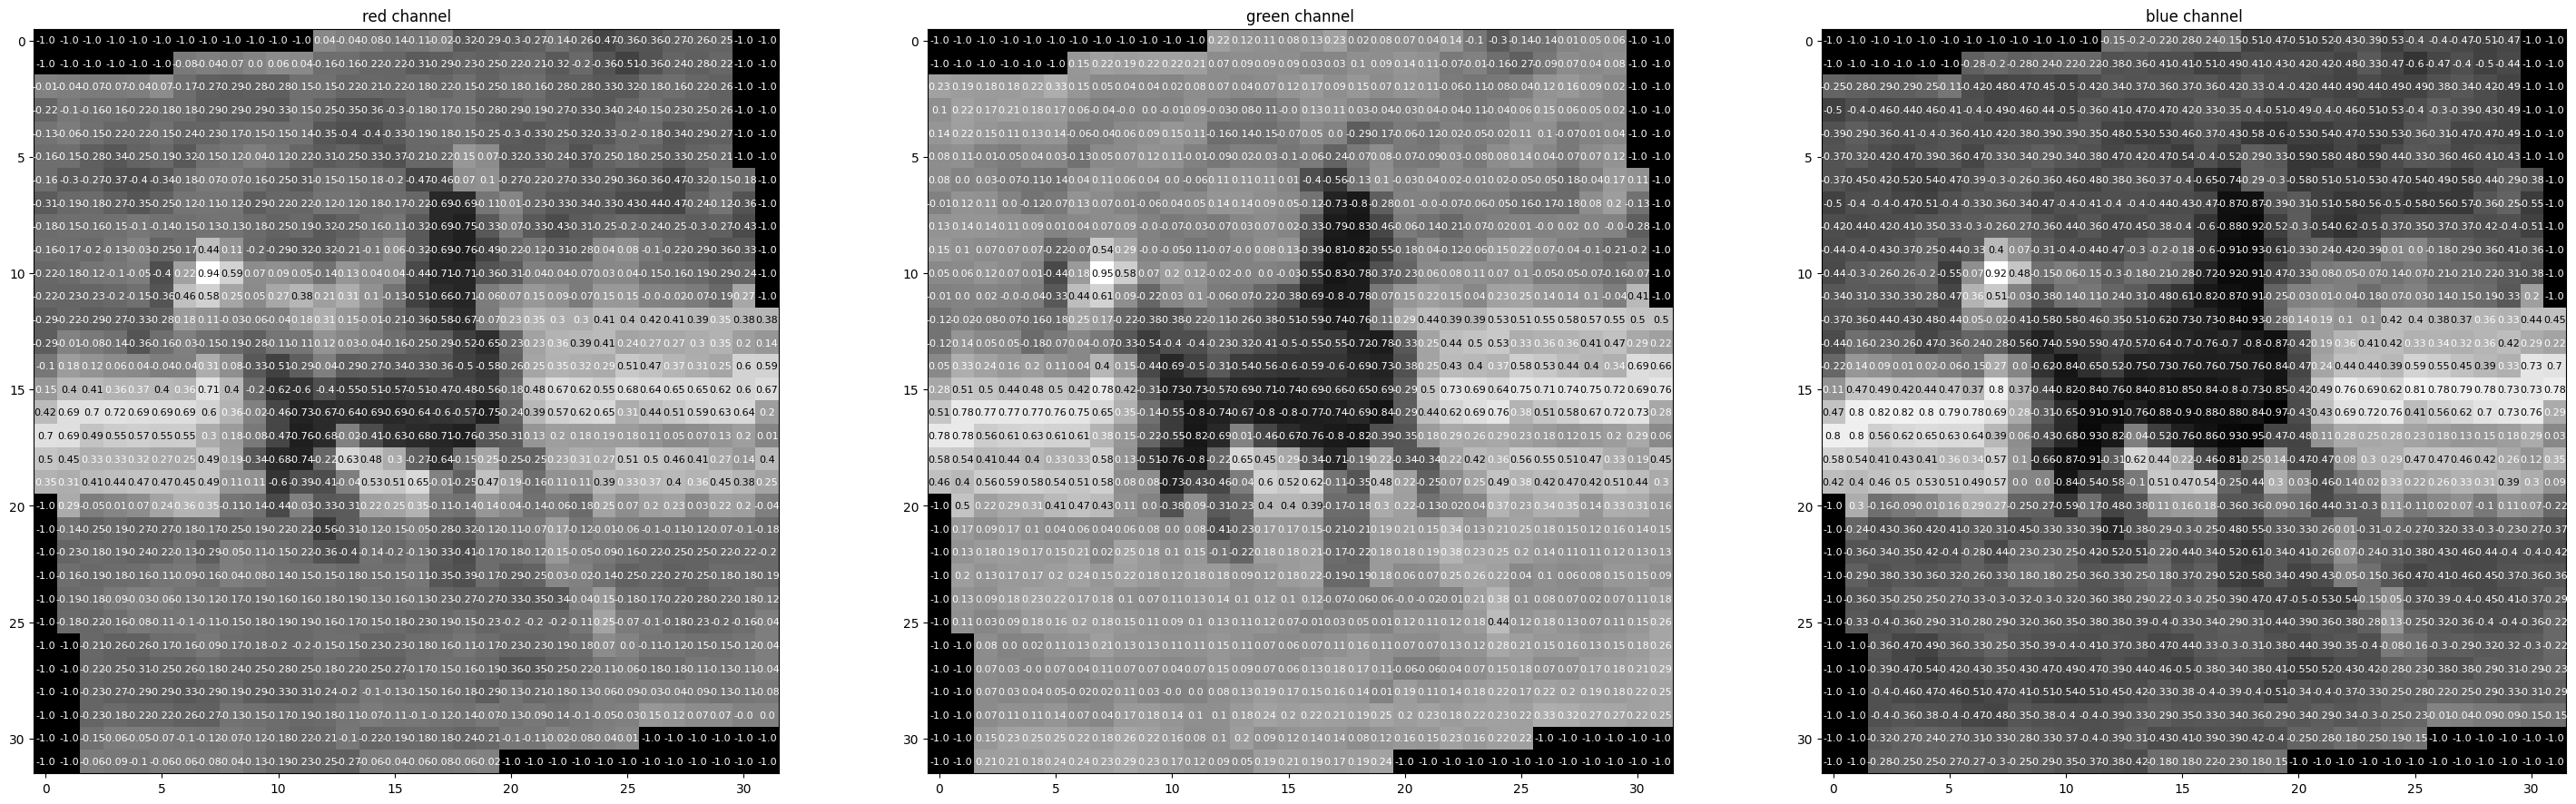

In [12]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

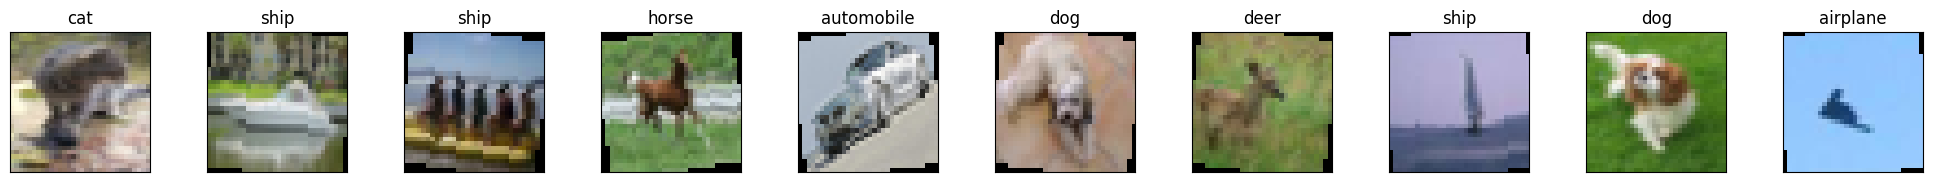

In [9]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 20, sampler = train_sampler, num_workers = number_of_workers)
valid_loader= torch.utils.data.DataLoader(train_data, batch_size = 20, sampler = valid_sampler, num_workers = number_of_workers)
test_loader= torch.utils.data.DataLoader(test_data, batch_size = 20, num_workers = number_of_workers)
class_names =['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in range(10):
  ax= fig.add_subplot(2 , 10 , idx+1 , xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(class_names[labels[idx]])

In [11]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

if train_on_gpu:
    images = images.cpu()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'

### Test CUDA

In [33]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

### Load the Data

In [34]:
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data.sampler import SubsetRandomSampler

number_of_workers = 0
valid_size= 0.2


#  Converting Data into a Normalized Tensor format
transform = transforms.Compose([
                                transforms.Resize(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std= (0.5, 0.5, 0.5))])

# Downloading training and testing Datasets
train_data= datasets.CIFAR10('data', train= True,
                             download= True, transform = transform)
test_data = datasets.CIFAR10('data', train = False,
                             download = True, transform= transform)

# Obtaining training Indices that we are going to use for Validation Set
num_train= len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
# 打乱索引顺序
split = int(np.floor(valid_size * num_train))
# 划分训练和验证
train_idx, valid_idx = indices[split:] , indices[:split]

# Defining samplers for training and validation Bathces
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

Files already downloaded and verified
Files already downloaded and verified


### The MobileVit model

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def conv_2d(inp, oup, kernel_size=3, stride=1, padding=0, groups=1, bias=False, norm=True, act=True):
    conv = nn.Sequential()
    conv.add_module('conv', nn.Conv2d(inp, oup, kernel_size, stride, padding, bias=bias, groups=groups))
    if norm:
        conv.add_module('BatchNorm2d', nn.BatchNorm2d(oup))
    if act:
        conv.add_module('Activation', nn.SiLU())
    return conv


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]
        hidden_dim = int(round(inp * expand_ratio))
        self.block = nn.Sequential()
        if expand_ratio != 1:
            self.block.add_module('exp_1x1', conv_2d(inp, hidden_dim, kernel_size=1, stride=1, padding=0))
        self.block.add_module('conv_3x3', conv_2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim))
        self.block.add_module('red_1x1', conv_2d(hidden_dim, oup, kernel_size=1, stride=1, padding=0, act=False))
        self.use_res_connect = self.stride == 1 and inp == oup

    def forward(self, x):
        if self.use_res_connect:
            return x + self.block(x)
        else:
            return self.block(x)  


class LinearSelfAttention(nn.Module):
    def __init__(self, embed_dim, attn_dropout=0):
        super().__init__()
        self.qkv_proj = conv_2d(embed_dim, 1 + 2 * embed_dim, kernel_size=1, bias=True, norm=False, act=False)
        self.attn_dropout = nn.Dropout(attn_dropout)
        self.out_proj = conv_2d(embed_dim, embed_dim, kernel_size=1, bias=True, norm=False, act=False)
        self.embed_dim = embed_dim

    def forward(self, x):
        qkv = self.qkv_proj(x)
        q, k, v = torch.split(qkv, split_size_or_sections=[1, self.embed_dim, self.embed_dim], dim=1)
        context_score = F.softmax(q, dim=-1)
        context_score = self.attn_dropout(context_score)

        context_vector = k * context_score
        context_vector = torch.sum(context_vector, dim=-1, keepdim=True)

        out = F.relu(v) * context_vector.expand_as(v)
        out = self.out_proj(out)
        return out


class LinearAttnFFN(nn.Module):
    def __init__(self, embed_dim, ffn_latent_dim, dropout=0, attn_dropout=0):
        super().__init__()
        self.pre_norm_attn = nn.Sequential(
            nn.GroupNorm(num_channels=embed_dim, eps=1e-5, affine=True, num_groups=1),
            LinearSelfAttention(embed_dim, attn_dropout),
            nn.Dropout(dropout)
        )
        self.pre_norm_ffn = nn.Sequential(
            nn.GroupNorm(num_channels=embed_dim, eps=1e-5, affine=True, num_groups=1),
            conv_2d(embed_dim, ffn_latent_dim, kernel_size=1, stride=1, bias=True, norm=False, act=True),
            nn.Dropout(dropout),
            conv_2d(ffn_latent_dim, embed_dim, kernel_size=1, stride=1, bias=True, norm=False, act=False),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        # self attention
        x = x + self.pre_norm_attn(x)
        # Feed Forward network
        x = x + self.pre_norm_ffn(x)
        return x


class MobileViTBlockv3(nn.Module):
    def __init__(self, inp, attn_dim, ffn_multiplier, attn_blocks, patch_size):
        super(MobileViTBlockv3, self).__init__()
        self.patch_h, self.patch_w = patch_size

        # local representation
        self.local_rep = nn.Sequential()
        self.local_rep.add_module('conv_3x3', conv_2d(inp, inp, kernel_size=3, stride=1, padding=1, groups=inp))
        self.local_rep.add_module('conv_1x1', conv_2d(inp, attn_dim, kernel_size=1, stride=1, norm=False, act=False))
        
        # global representation
        self.global_rep = nn.Sequential()
        ffn_dims = [int((ffn_multiplier * attn_dim)//16*16)] * attn_blocks
        for i in range(attn_blocks):
            ffn_dim = ffn_dims[i]
            self.global_rep.add_module(f'LinearAttnFFN_{i}', LinearAttnFFN(attn_dim, ffn_dim))
        self.global_rep.add_module('LayerNorm2D', nn.GroupNorm(num_channels=attn_dim, eps=1e-5, affine=True, num_groups=1))

        self.conv_proj = conv_2d(2*attn_dim, inp, kernel_size=1, stride=1, padding=0, act=False)

    def unfolding_pytorch(self, feature_map):
        batch_size, in_channels, img_h, img_w = feature_map.shape
        # [B, C, H, W] --> [B, C, P, N]
        patches = F.unfold(
            feature_map,
            kernel_size=(self.patch_h, self.patch_w),
            stride=(self.patch_h, self.patch_w),
        )
        patches = patches.reshape(
            batch_size, in_channels, self.patch_h * self.patch_w, -1
        )
        return patches, (img_h, img_w)

    def folding_pytorch(self, patches, output_size):
        batch_size, in_dim, patch_size, n_patches = patches.shape
        # [B, C, P, N]
        patches = patches.reshape(batch_size, in_dim * patch_size, n_patches)
        feature_map = F.fold(
            patches,
            output_size=output_size,
            kernel_size=(self.patch_h, self.patch_w),
            stride=(self.patch_h, self.patch_w),
        )
        return feature_map

    def forward(self, x):
        res = x.clone()
        fm_conv = self.local_rep(x)
        x, output_size = self.unfolding_pytorch(fm_conv)
        x = self.global_rep(x)
        x = self.folding_pytorch(patches=x, output_size=output_size)
        x = self.conv_proj(torch.cat((x, fm_conv), dim=1))
        x = x + res
        return x


class MobileViTv3(nn.Module):
    def __init__(self, image_size, width_multiplier, num_classes, patch_size=(2, 2)):
        
        super().__init__()
        # check image size
        ih, iw = image_size
        self.ph, self.pw = patch_size
        assert ih % self.ph == 0 and iw % self.pw == 0 
        assert width_multiplier in [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]

        # model size
        channels = []
        channels.append(int(max(16, min(64, 32 * width_multiplier))))
        channels.append(int(64 * width_multiplier))
        channels.append(int(128 * width_multiplier))
        channels.append(int(256 * width_multiplier))
        channels.append(int(384 * width_multiplier))
        channels.append(int(512 * width_multiplier))
        attn_dim = []
        attn_dim.append(int(128 * width_multiplier))
        attn_dim.append(int(192 * width_multiplier))
        attn_dim.append(int(256 * width_multiplier))

        ffn_multiplier = 2
        mv2_exp_mult = 2

        self.conv_0 = conv_2d(3, channels[0], kernel_size=3, stride=2)

        self.layer_1 = nn.Sequential(
            InvertedResidual(channels[0], channels[1], stride=1, expand_ratio=mv2_exp_mult)
        )
        self.layer_2 = nn.Sequential(
            InvertedResidual(channels[1], channels[2], stride=2, expand_ratio=mv2_exp_mult),
            InvertedResidual(channels[2], channels[2], stride=1, expand_ratio=mv2_exp_mult)
        )
        self.layer_3 = nn.Sequential(
            InvertedResidual(channels[2], channels[3], stride=2, expand_ratio=mv2_exp_mult),
            MobileViTBlockv3(channels[3], attn_dim[0], ffn_multiplier, 2, patch_size=patch_size)
        )
        self.layer_4 = nn.Sequential(
            InvertedResidual(channels[3], channels[4], stride=2, expand_ratio=mv2_exp_mult),
            MobileViTBlockv3(channels[4], attn_dim[1], ffn_multiplier, 4, patch_size=patch_size)
        )
        self.layer_5 = nn.Sequential(
            InvertedResidual(channels[4], channels[5], stride=2, expand_ratio=mv2_exp_mult),
            MobileViTBlockv3(channels[5], attn_dim[2], ffn_multiplier, 3, patch_size=patch_size)
        )
        self.out = nn.Linear(channels[-1], num_classes, bias=True)

    def forward(self, x):
        x = self.conv_0(x)
        x = self.layer_1(x)
        x = self.layer_2(x) 
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.layer_5(x)
        
        # FF head
        x = torch.mean(x, dim=[-2, -1])
        x = self.out(x)

        return x

### Train and validate the MobileVit model

Epoch: 1 	Training Loss: 1.142666 	Validation Loss: 0.191299
Validation loss decreased (inf --> 0.191299).  Saving model ...
---------------------------------------------------------------------------------------------------
Epoch: 2 	Training Loss: 0.759034 	Validation Loss: 0.148212
Validation loss decreased (0.191299 --> 0.148212).  Saving model ...
---------------------------------------------------------------------------------------------------
Epoch: 3 	Training Loss: 0.614033 	Validation Loss: 0.128023
Validation loss decreased (0.148212 --> 0.128023).  Saving model ...
---------------------------------------------------------------------------------------------------
Epoch: 4 	Training Loss: 0.525449 	Validation Loss: 0.114943
Validation loss decreased (0.128023 --> 0.114943).  Saving model ...
---------------------------------------------------------------------------------------------------
Epoch: 5 	Training Loss: 0.461544 	Validation Loss: 0.107050
Validation loss decrease

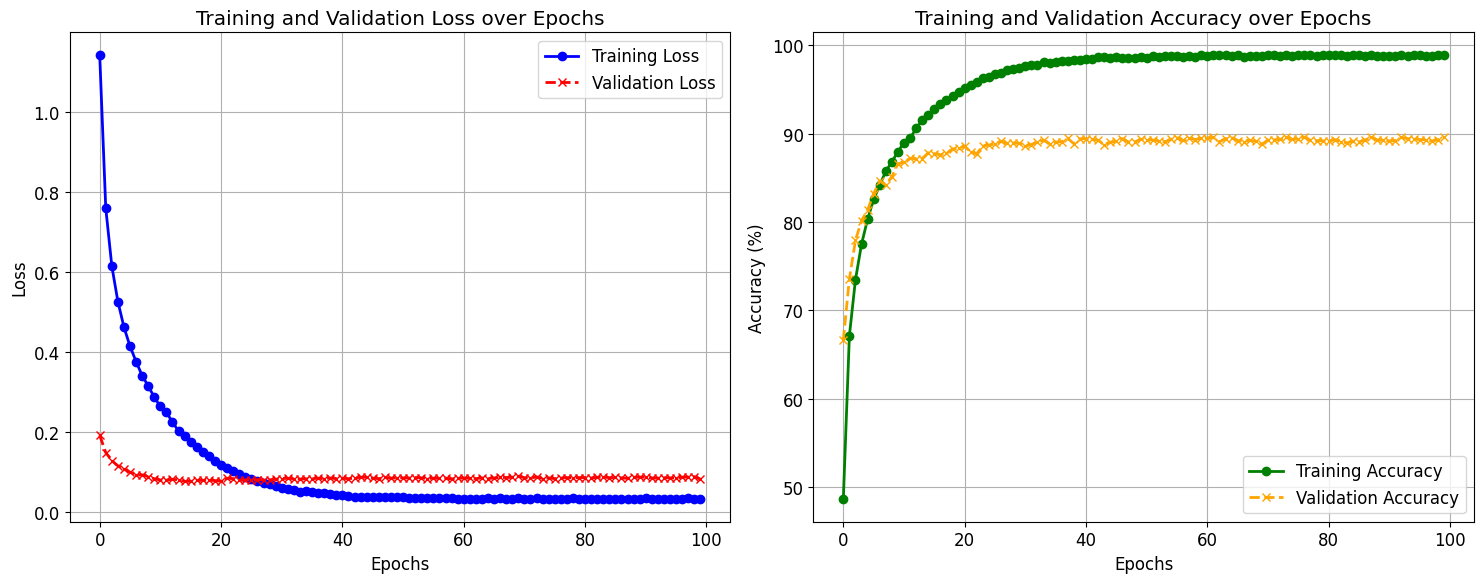

In [36]:
import torch.optim as optim
import itertools
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt

# Define parameters
batch_size = 10
learning_rate = 1e-3
n_epochs = 100
class_names =['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
model_filename = f'model_MobileVit_cifar10.pt'

# Creating model instances
model = MobileViTv3(image_size = (224, 224), width_multiplier = 1, num_classes = 10, patch_size = (2, 2)).cuda()

# Update DataLoaders
# Preparing Data Loader for all three sets (combining datasets and samplers)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = train_sampler , num_workers = number_of_workers)
valid_loader= torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = valid_sampler, num_workers = number_of_workers)
test_loader= torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers = number_of_workers)

# Specify loss function
criterion = nn.CrossEntropyLoss()

# Specify optimizer
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9, weight_decay = 0.001)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Track change in validation loss
valid_loss_min = np.Inf

# Storage loss and accuracy
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
    
for epoch in range(1, n_epochs + 1):
        
    # Keep track of training, validation loss and training, validation accuracy
    train_loss = 0.0
    valid_loss = 0.0
    train_correct_number = 0
    train_total_total_number = 0
    valid_correct_number = 0
    total_total_valid_number = 0
    
    ############################
    # train the baseline model #
    ############################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda() 
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss and accuracy
        train_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output, 1)
        train_correct_number += (predicted == target).sum().item()
        train_total_total_number += target.size(0)
        
    ###############################    
    # validate the baseline model #
    ###############################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss and accuracy
        valid_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output, 1)
        valid_correct_number += (predicted == target).sum().item()
        total_total_valid_number += target.size(0)
            
    scheduler.step()
    
    # Calculation of average loss and accuracy
    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(100 * train_correct_number / train_total_total_number)
    valid_accuracies.append(100 * valid_correct_number / total_total_valid_number)
        
    # Print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    
    # Save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
        print('---------------------------------------------------------------------------------------------------')
        torch.save(model.state_dict(), model_filename)
        valid_loss_min = valid_loss
    else:
        print('---------------------------------------------------------------------------------------------------')

        
# Setting the global font size
plt.rcParams.update({'font.size': 12})

# Plotting loss curves
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, color='blue', label='Training Loss', marker='o', linestyle='-', linewidth=2, markersize=6)
plt.plot(valid_losses, color='red', label='Validation Loss', marker='x', linestyle='--', linewidth=2, markersize=6)
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plotting accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, color='green', label='Training Accuracy', marker='o', linestyle='-', linewidth=2, markersize=6)
plt.plot(valid_accuracies, color='orange', label='Validation Accuracy', marker='x', linestyle='--', linewidth=2, markersize=6)
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig('mobileVit_model_training_validation_curves.png', format='png', dpi=300)
plt.show()